In [1]:
import os
import random
import numpy as np
from io import BytesIO

# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

# Interactive widgets
from ipywidgets import widgets

2024-11-10 00:11:05.713834: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
base_dir = 'rps'

rock_dir = os.path.join(base_dir,'rock')
paper_dir = os.path.join(base_dir,'paper')
scissors_dir = os.path.join(base_dir,'scissors')

rock_dir_files = os.listdir(rock_dir)
paper_dir_files = os.listdir(paper_dir)
scissor_dir_files = os.listdir(scissors_dir)

print("no. of rock_files:",len(rock_dir_files))
print("no. of paper_files:",len(paper_dir_files))
print("no. of scissor files:",len(scissor_dir_files))

no. of rock_files: 840
no. of paper_files: 840
no. of scissor files: 840


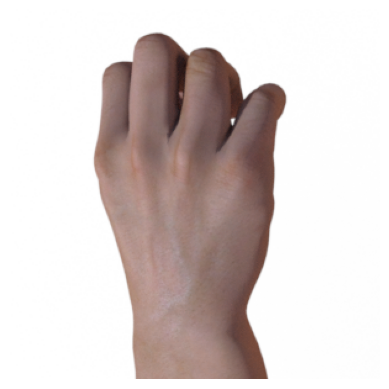

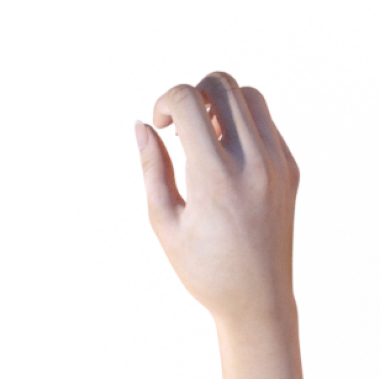

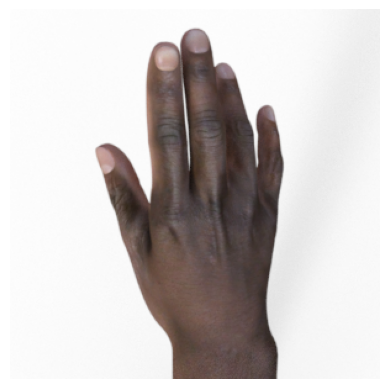

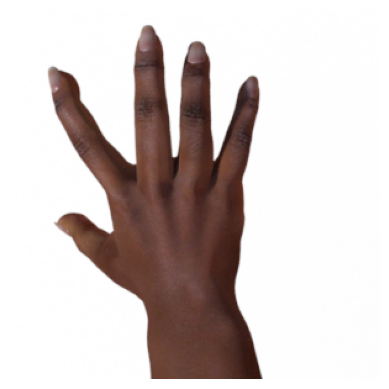

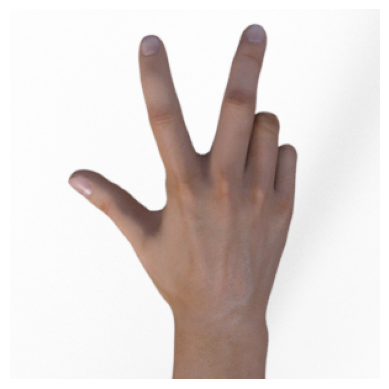

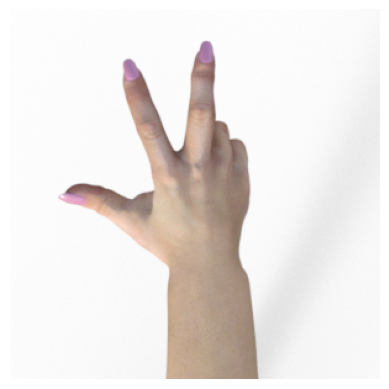

In [5]:
next_rock = [os.path.join(rock_dir, fname)
             for fname in random.sample(rock_dir_files, k=2)]
next_paper = [os.path.join(paper_dir, fname)
              for fname in random.sample(paper_dir_files, k=2)]
next_scissors = [os.path.join(scissors_dir, fname)
                 for fname in random.sample(scissor_dir_files, k=2)]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

In [7]:
model = tf.keras.Sequential([
    tf.keras.Input(shape = (150,150,3)),
    tf.keras.layers.Rescaling(.1/255),
    
    tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512,activation = 'relu'),
    tf.keras.layers.Dense(1,activation = 'softmax')
])

model.summary()

2024-11-10 00:24:01.145120: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       7

In [31]:
training_dir = 'rps'
validation_dir = 'rps-test-set'

training_dataset = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    image_size = (150,150),
    batch_size = 32,
    label_mode = 'categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size = (150,150),
    batch_size = 32,
    label_mode = 'categorical'
)

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


In [32]:
shuffle_buffer_size = 1000
prefetch_buffer_size = tf.data.AUTOTUNE

training_dataset_final = training_dataset.cache().shuffle(buffer_size = shuffle_buffer_size).prefetch(buffer_size = prefetch_buffer_size)
validation_dataset_final = validation_dataset.cache().shuffle(buffer_size = shuffle_buffer_size).prefetch(buffer_size = prefetch_buffer_size)

In [40]:
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape = (150,150,3)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.4,fill_mode = 'nearest'),
    tf.keras.layers.RandomTranslation(0.2,0.2,fill_mode = 'nearest'),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2,fill_mode = 'nearest')
])

In [41]:
augumented_model = tf.keras.Sequential(data_augmentation,model)

In [42]:
model.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [43]:
EPOCHS = 20

model.fit(training_dataset_final,
          epochs = EPOCHS,
          validation_data = validation_dataset_final,
          verbose = 1
         )

Epoch 1/20


ValueError: in user code:

    File "/home/code-dilip/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/code-dilip/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/code-dilip/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/code-dilip/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/code-dilip/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/home/code-dilip/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/code-dilip/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/code-dilip/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/code-dilip/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/code-dilip/anaconda3/envs/Machine_Learning/lib/python3.11/site-packages/keras/backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 3) and (None, 1) are incompatible


In [ ]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

In [ ]:
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0]

    with out:

        print(f'\nmodel output: {prediction}')
        
        prediction_index = np.argmax(prediction)
        
        classes = ["paper", "rock", "scissors"]
        
        predicted_class = classes[prediction_index]
        
        print(f'{filename} is {predicted_class}')


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')